# Machine Learning Pipelines

# Models as a task graph (DAG)
<img src="../part_1/img/rolson17-ml-pipeline.png">
<div style="text-align: right">Source: R. Olson et. al. (2017) "Data-driven Advice for Applying Machine Learning to Bioinformatics Problems."</div>

# Why a DAG?

### Encapsulation

Feature engineering operators, post-processing (e.g. calibration) are part of your model.

### Optimization

Feature engineering operators have hyper-parameters too. Furthermore, we want to search over graphs.

### Safety

Ensure that no information from testing can "leak" into the model fitting phase.

### Train-test-skew

Contracts between operators are more subtle than just message schemas; assumptions about the data distribution are included as well. Operators must not change after the model was fit!

# Pipelines in Scikit-learn

### [Pipeline](https://scikit-learn.org/stable/modules/compose.html#pipeline)

A linear sequence of `Estimator` objects that represent a fixed set of steps, often feature extraction, normalization and classification. It implements the [Composite design pattern (GoF)](https://en.wikipedia.org/wiki/Composite_pattern).

All estimators in a pipeline, except the last one, must be transformers (i.e. must have a `transform` method).

Pipelines allow nested parameters:
```python

est = Pipeline(steps=[('scaler', StandardScaler()), ('lr', LinearRegression())])
est.set_params(scaler__with_std=False)
```

### Exercise 2.1.1

Build a `Pipeline` version of the `PolynomialRegressor` and search for the optimal `degree` of the polynomial.

In [1]:
%run ../part_1/utils.py

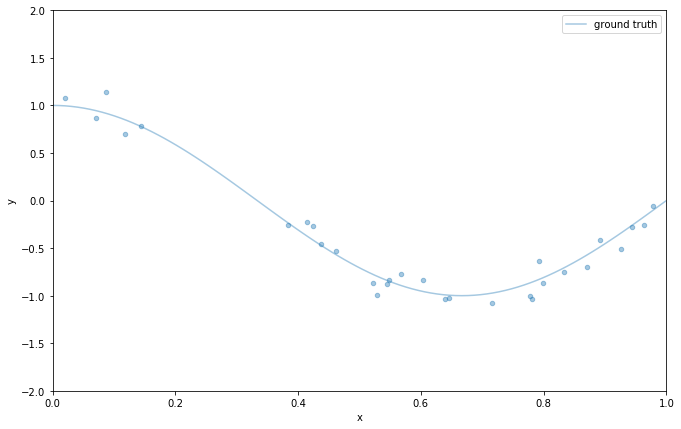

In [2]:
X, y = generate_curve_data()
fig = plot_data(X, y, fn=true_fn)

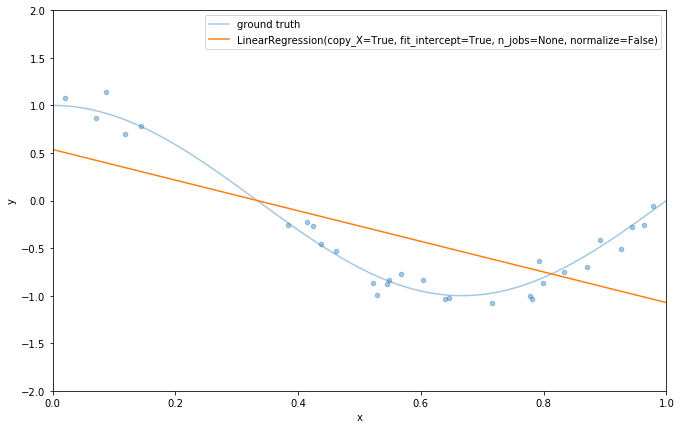

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Excercise: change this estimator to polynomial regression
est = LinearRegression()

gs = GridSearchCV(estimator=est, param_grid={}, 
                  scoring='neg_mean_squared_error', cv=3)

gs.fit(X[:, np.newaxis], y)

fig = plot_data(X, y, fn=true_fn)
plot_estimator(gs.best_estimator_, fig)

# Beyond a chain of estimators


### [FeatureUnion](https://scikit-learn.org/stable/modules/compose.html#featureunion-composite-feature-spaces)

Combines several transformer objects into a new transformer that combines their output.
Takes a list of transformer objects, each of which is fit to the data independently. 
The transformers are applied in parallel, and the feature matrices they output are concatenated side-by-side into a wider matrix (via `np.hstack`).

```python
feature_extractors = [('poly', PolynomialFeatures()), ('pca', PCA())]
est = Pipeline(steps=[('fu_1', FeatureUnion(feature_extractors)), 
                      ('rfe', RFE(LinearRegression(), 5, step=1)), 
                      ('lr', LinearRegression())])
```

### Caching of transformers

Pipelines can do [caching](https://scikit-learn.org/stable/modules/compose.html#caching-transformers-avoid-repeated-computation) via `memory` which helps to avoid repeated computation. 

# Working with heterogenous data sources

### [ColumnTransformer](https://scikit-learn.org/stable/modules/compose.html#columntransformer-for-heterogeneous-data)

Many datasets contain features of different types, say text, numeric, categorical, and dates, where each type of feature requires separate preprocessing or feature extraction steps.

This component is still experimental in 0.21.

```python
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
column_trans = ColumnTransformer(
    [('city_category', OneHotEncoder(dtype='int'),['city']),
     ('title_bow', CountVectorizer(), 'title')],
    remainder='drop')
```

# Kaggle Time!

### Dataset

[Blue Book for Bulldozers (aka Fastiron) Kaggle competition](https://www.kaggle.com/c/bluebook-for-bulldozers/data). 

Predict the auction sale price for a piece of heavy equipment to create a "blue book" for bulldozers.

Performance metric: mean absolute error (MAE).

In [4]:
import pandas as pd

url = 'https://s3.amazonaws.com/datarobot_public_datasets/fastiron-train-sample_80.csv'
df = pd.read_csv('../fastiron-train-sample_80.csv', parse_dates=['saledate'])
df['saledate'] = df['saledate'].astype(np.int64)
target_feature = 'SalePrice'
categorical_features = ['UsageBand', 'fiBaseModel', 'fiModelDesc', 
                        'fiModelSeries', 'ProductSize',
                        'state', 'ProductGroup', 'ProductGroupDesc','Enclosure',
                        'Enclosure_Type', 'Tire_Size',
                        ]
numeric_features = ['MachineID', 'ModelID', 'datasource', 'YearMade', 'saledate']
text_features = ['fiProductClassDesc']

y = df.pop(target_feature)
X = df

In [5]:
df

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,6319865,1817345,18180,149,1.0,2006,NaN,NaN,1313539200000000000,EC460BLC,...,None or Unspecified,"11' 0""",None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
1,1520091,1515216,2758,132,1.0,1996,NaN,NaN,971308800000000000,D5CIII,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
2,1789487,1251936,9560,132,2.0,1985,NaN,NaN,1088208000000000000,843,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1266711,1068934,3257,132,3.0,1995,NaN,NaN,1132185600000000000,9040B,...,32 inch,None or Unspecified,Hydraulic,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
4,1254972,1179567,6742,132,1.0,1978,NaN,NaN,676166400000000000,450,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN
5,6259295,1933759,13247,149,99.0,2007,NaN,NaN,1322697600000000000,580MII,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1671041,1445543,8588,132,99.0,1000,NaN,NaN,862876800000000000,755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1628397,1532974,4603,132,1.0,1996,NaN,NaN,1050451200000000000,310D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1383883,731939,23926,132,8.0,1995,NaN,NaN,1284508800000000000,12HNA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2413426,1194806,590,136,1.0,1996,0.0,NaN,1214438400000000000,WA250-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional


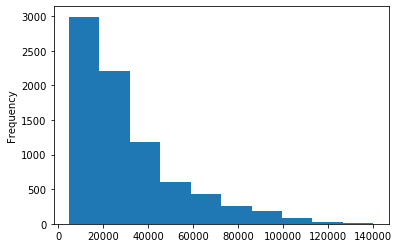

In [6]:
y.plot.hist(50)

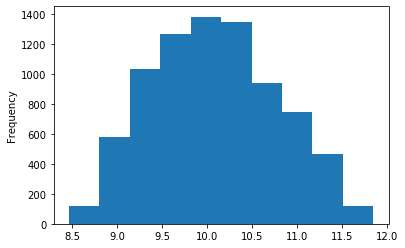

In [7]:
y_log1p = np.log1p(y)
y_log1p.plot.hist(50)

In [8]:
from utils import ColumnGroupSelector
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)


numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

## Categorical pipeline
# categorical_pipeline = Pipeline(steps=[...])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ## ('cat', categorical_pipeline, categorical_features),
    ])

# Append estimator to preprocessing pipeline.
# Now we have a full prediction pipeline.
est = Pipeline(steps=[('preprocessor', preprocessor),
                      ('lr', LinearRegression())])

est.fit(X_train, y_train)
print("model score: %.3f" % mean_absolute_error(y_test, est.predict(X_test)))

model score: 16845.013


/home/peter/anaconda3/envs/aml2/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Exercise 2.1.2

Implement the following pipeline:

<img src="img/exercise_2_1_2.png">

And tune hyper-parameters:
  * `RandomForestRegressor(criterion='mse')` with `['mse', 'mae']`

In [9]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import ShuffleSplit


numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-99999)),
    ])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('fx_selection', SelectFromModel(ElasticNet(l1_ratio=1.0), max_features=100, threshold=None))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
    ])

# Append estimator to preprocessing pipeline.
# Now we have a full prediction pipeline.
est = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rf', RandomForestRegressor(n_estimators=20, n_jobs=-1))])

# Use a simple train-test split for GridSearch
_, test_split = next(iter(ShuffleSplit(test_size=0.2, random_state=0).split(X_train)))
ps = PredefinedSplit(test_split)
gs = GridSearchCV(estimator=est, param_grid={'rf__criterion': ['mse', 'mae']}, 
                  scoring='neg_mean_absolute_error', cv=2, refit=True, verbose=10)

gs.fit(X_train, y_train)

print("best params: {}".format(gs.best_params_))
print("model score: %.3f" % mean_absolute_error(y_test, gs.best_estimator_.predict(X_test)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] rf__criterion=mse ...............................................


/home/peter/anaconda3/envs/aml2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3827265793.1033936, tolerance: 158037064.19091797
  max_iter, tol, rng, random, positive)


[CV] ............... rf__criterion=mse, score=-9836.949, total=  13.1s
[CV] rf__criterion=mse ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.1s remaining:    0.0s
/home/peter/anaconda3/envs/aml2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 706171012.9077454, tolerance: 168623613.52653384
  max_iter, tol, rng, random, positive)


[CV] ............... rf__criterion=mse, score=-9516.001, total=  12.2s
[CV] rf__criterion=mae ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   25.3s remaining:    0.0s
/home/peter/anaconda3/envs/aml2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3827265793.1033936, tolerance: 158037064.19091797
  max_iter, tol, rng, random, positive)


[CV] ............... rf__criterion=mae, score=-9551.908, total=  13.2s
[CV] rf__criterion=mae ...............................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   38.5s remaining:    0.0s
/home/peter/anaconda3/envs/aml2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 706171012.9077454, tolerance: 168623613.52653384
  max_iter, tol, rng, random, positive)


[CV] ............... rf__criterion=mae, score=-9239.349, total=  13.2s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   51.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   51.6s finished
/home/peter/anaconda3/envs/aml2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:459: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9801265629.603516, tolerance: 326692701.4462798
  max_iter, tol, rng, random, positive)


best params: {'rf__criterion': 'mae'}
model score: 8459.503


In [ ]:
# Exercise 2.1.2

Implement the following pipeline:

<img src="img/exercise_2_1_2.png">

And tune hyper-parameters:
  * `RandomForestRegressor(criterion='mse')` with `['mse', 'mae']`

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-99999)),
    ])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('fx_selection', SelectFromModel(ElasticNet(l1_ratio=1.0), max_features=100, threshold=None))
])

text_pipeline = Pipeline(steps=[
    ('bow', CountVectorizer()),
    ('bow_reg', ElasticNet())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features),
        ('text', text_pipeline, text_features)
    ])

# Append estimator to preprocessing pipeline.
# Now we have a full prediction pipeline.
est = Pipeline(steps=[('preprocessor', preprocessor),
                      ('rf', RandomForestRegressor(n_estimators=20, criterion='mae', n_jobs=-1))])

# Use a simple train-test split for GridSearch
#_, test_split = next(iter(ShuffleSplit(test_size=0.2, random_state=0).split(X_train)))
#ps = PredefinedSplit(test_split)
#gs = GridSearchCV(estimator=est, param_grid={'rf__criterion': ['mse', 'mae']}, 
#                  scoring='neg_mean_absolute_error', cv=2, refit=True, verbose=10)

#gs.fit(X_train, y_train)
est.fit(X_train, y_train)

#print("best params: {}".format(gs.best_params_))
print("model score: %.3f" % mean_absolute_error(y_test, est.predict(X_test)))

TypeError: All estimators should implement fit and transform, or can be 'drop' or 'passthrough' specifiers. 'Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('bow_reg',
                 ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                            l1_ratio=0.5, max_iter=1000, normalize=False,
                            positive=False, precompute=False, random_state=None,
                            selection='cyclic', tol=0.0001,
                            warm_start=False))],
         verbose=False)' (type <class 'sklearn.pipeline.Pipeline'>) doesn't.